# Julia Academy

## Data Science Course

# 4. Dimensionality Reduction in Julia

**Huda Nassar**

**Source:** https://github.com/JuliaAcademy/DataScience/blob/main/04.%20Dimensionality%20Reduction.ipynb

When we have more than two variables, we can use dimensionality reduction techniques to reduce the dataset to a smaller number of latent feature variables. Dimensionality reduction is used in exploratory data analysis to visualize data, but also used as an information compression tool in machine learning algorithms (eg Variational Autoencoder)

In [29]:
using UMAP
using XLSX
using VegaDatasets
using DataFrames
using MultivariateStats
using RDatasets
using StatsBase
using Statistics
using LinearAlgebra
using Plots
using ScikitLearn
using MLBase
using Distances
using TSne

┌ Info: Precompiling TSne [24678dba-d5e9-5843-a4c6-250288b04835]
└ @ Base loading.jl:1278


We'll use the cars dataset (same as from the DataFrames.jl course). This dataset contains engine measurements for over 400 types of cars.

In [5]:
ENV["LINES"], ENV["COLUMNS"] = 15, 200

(15, 200)

In [6]:
cars = DataFrame(VegaDatasets.dataset("cars"))
dropmissing!(cars)

,Name,Miles_per_Gallon,Cylinders,Displacement,Horsepower,Weight_in_lbs,Acceleration,Year,Origin
,String,Float64,Int64,Float64,Int64,Int64,Float64,String,String
1,chevrolet chevelle malibu,18.0,8,307.0,130,3504,12.0,1970-01-01,USA
2,buick skylark 320,15.0,8,350.0,165,3693,11.5,1970-01-01,USA
3,plymouth satellite,18.0,8,318.0,150,3436,11.0,1970-01-01,USA
4,amc rebel sst,16.0,8,304.0,150,3433,12.0,1970-01-01,USA
5,ford torino,17.0,8,302.0,140,3449,10.5,1970-01-01,USA
6,ford galaxie 500,15.0,8,429.0,198,4341,10.0,1970-01-01,USA
7,chevrolet impala,14.0,8,454.0,220,4354,9.0,1970-01-01,USA
8,plymouth fury iii,14.0,8,440.0,215,4312,8.5,1970-01-01,USA
9,pontiac catalina,14.0,8,455.0,225,4425,10.0,1970-01-01,USA


We will store a matrix version of the data for use in dimension reducing algorithms (excluding the name, year and origin columns)

In [7]:
M = Matrix(cars[:, 2:7]);

We'll also store the origin column as a vector

In [9]:
car_origins = cars[:, :Origin];

However we would like a unique integer representation of each origin. We can do this easily using `MLBase`

In [10]:
car_origin_map = MLBase.labelmap(car_origins)
car_origin_ids = MLBase.labelencode(car_origin_map, car_origins)

392-element Array{Int64,1}:
 1
 1
 1
 1
 1
 ⋮
 1
 3
 1
 1
 1

## PCA

The first dimensionality reduction technique we'll look at is principle component analysis. First we need to center and normalize the data (so that the magnitudes of each feature variable are equivalent)

In [14]:
data = copy(M)
data = (data .- mean(data, dims=1)) ./ std(data, dims=1);   # taking mean and standard deviation of each column; and standardizing row-wise

392×6 Array{Float64,2}:
 -0.697747   1.48205    1.07591    0.663285   0.619748  -1.28362
 -1.08212    1.48205    1.48683    1.57258    0.842258  -1.46485
 -0.697747   1.48205    1.18103    1.18288    0.539692  -1.64609
 -0.953992   1.48205    1.04725    1.18288    0.53616   -1.28362
 -0.82587    1.48205    1.02813    0.923085   0.554997  -1.82732
  ⋮                                                      ⋮
  0.455359  -0.862911  -0.519972  -0.479835  -0.220842   0.0212673
  2.63345   -0.862911  -0.930889  -1.36315   -0.997859   3.28348
  1.09597   -0.862911  -0.567753  -0.531795  -0.803605  -1.4286
  0.583482  -0.862911  -0.711097  -0.661694  -0.415097   1.10867
  0.967851  -0.862911  -0.720653  -0.583754  -0.303253   1.39865

> **Note:** PCA expects each column to be an observation, instead of the rows. So we will transpose:

In [13]:
pca_model = fit(PCA, data', maxoutdim=2)   # from MultivariateStats

PCA(indim = 6, outdim = 2, principalratio = 0.919482878533357)

From this we want a projection matrix which we can apply to the input data:

In [15]:
P = projection(pca_model)

6×2 Array{Float64,2}:
  0.398973  -0.244835
 -0.430615   0.148314
 -0.443531   0.108497
 -0.434122  -0.166158
 -0.430103   0.286095
  0.291926   0.892652

We will use the projection matrix to convert a 6-element sample to a 2-element latent sample:

In [17]:
data[1,:]

6-element Array{Float64,1}:
 -0.6977467192333159
  1.482053026528959
  1.0759145865834074
  0.6632850838855419
  0.6197483279305314
 -1.2836175968153303

In [16]:
P' * (adata[1,:] - mean(pca_model))

2-element Array{Float64,1}:
 -2.323001696522693
 -0.5713519642644689

We can apply this more efficiently to the whole dataset as follows:

In [18]:
data_pca = MultivariateStats.transform(pca_model, data')

2×392 Array{Float64,2}:
 -2.323     -3.20196  -2.66658   -2.60214   -2.59658  -4.39584  -4.91344  -4.82935  -4.90421  -4.05041  …  -0.468293   1.10264   1.53475  1.10051    1.09338   3.81463   1.22011  1.70921   1.86951
 -0.571352  -0.68187  -0.992744  -0.621975  -1.0922   -1.00949  -1.36635  -1.53521  -1.03943  -1.66611     -0.222508  -1.04837  -1.52194  0.337723  -0.260354  1.99828  -1.87471  0.632857  0.815607

> **Note:** if we wanted to go back to 6 dimensions, we can reconstruct the dataset from the projections. But note that this process is lossy:

In [20]:
data_pca_emb = reconstruct(pca_model, data_pca)

6×392 Array{Float64,2}:
 -0.786928  -1.11055  -0.820834  -0.885903  -0.768559  -1.50666  -1.6258   -1.55091  -1.70216  -1.20808  …   0.696602   0.984946   0.356388   0.499974    1.03268   0.945785   0.526984   0.546196
  0.91558    1.27768   1.00103    1.02827    0.95614    1.74319   1.91315   1.8519    1.95766   1.49706     -0.630303  -0.88661   -0.423808  -0.509441   -1.34626  -0.803445  -0.64215   -0.684075
  0.968334   1.34619   1.075      1.08665    1.03317    1.84016   2.03102   1.9754    2.06239   1.61571     -0.602802  -0.845834  -0.451469  -0.513197   -1.4751   -0.744559  -0.689425  -0.740696
  1.1034     1.50334   1.32257    1.23299    1.30871    2.07606   2.36006   2.35161   2.30173   2.03521     -0.304486  -0.413383  -0.533871  -0.431401   -1.98804  -0.218179  -0.847159  -0.947116
  0.835669   1.18209   0.862883   0.941244   0.804326   1.60185   1.72238   1.6379    1.81194   1.26543     -0.774184  -1.09552   -0.376712  -0.544753   -1.06898  -1.06112   -0.554079  -0.570742
 

In [21]:
norm(data_pca_emb - data')

13.74384105556901

### PCA Visualisation

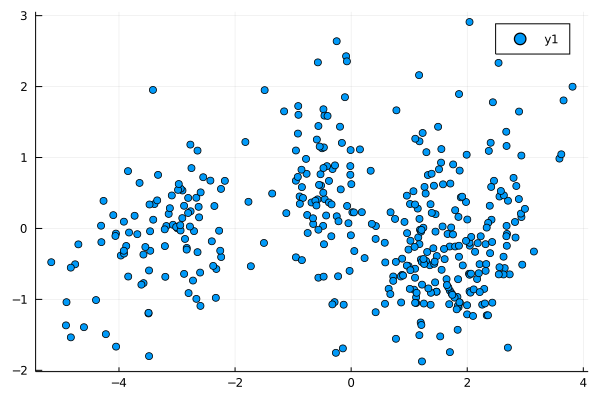

In [22]:
scatter(data_pca[1, :], data_pca[2, :])

At first glance we notice some sort of clustering but let's use the origin column (which we are tacitly treating as a label) to see how effective PCA has been:

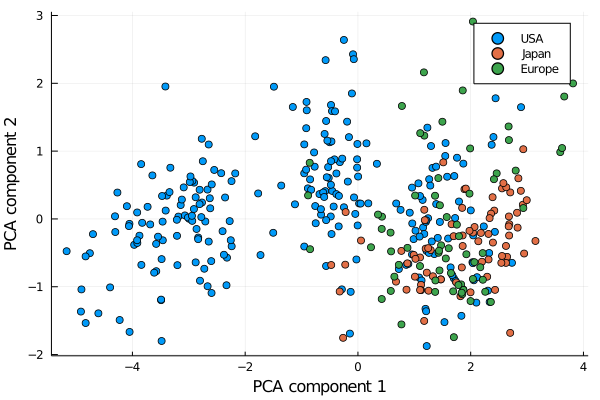

In [25]:
# we can use the `cars_origin` vector to efficiently index into the columns of the PCA projection
plot()
for (col_idx, origin_name) in enumerate(["USA", "Japan", "Europe"])
    scatter!(data_pca[1, car_origins.==origin_name], 
             data_pca[2, car_origins.==origin_name],
             color=col_idx,
             label=origin_name)
end
xlabel!("PCA component 1")
ylabel!("PCA component 2")

Now we see that the American cars dominate two of the clusters, with the Japanese and European cars mixed around the third cluster.

We could also do PCA in 3 dimensions:

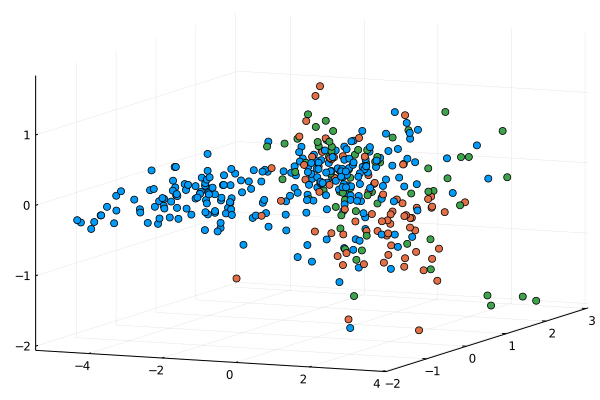

In [28]:
p = fit(PCA, data',maxoutdim=3)
pca3 = MultivariateStats.transform(p, data')
scatter3d(pca3[1,:], pca3[2,:], pca3[3,:],
          color=car_origin_ids, legend=false, grid=true)

## t-SNE

[t-Distributed Stochastic Neighbor Embedding](https://lvdmaaten.github.io/tsne/) is a technique developed by Laurend van der Maaten and Geoffrey Hinton in 2008. It is a more sophisticated version of PCA, incoporating distributional information, and is a popular dimensionality reduction technique in machine learning and data scienc circles.

In [40]:
data_tsne = tsne(data, 2, 50, 1000, 20.0)   # out dims, reduce dims (early exaggeration), max iterations, perplexity

Computing t-SNE 15%|███████████████████████▌                                                                                                                                    |  ETA: 0:00:01

Computing t-SNE 43%|███████████████████████████████████████████████████████████████████▎                                                                                        |  ETA: 0:00:00

Computing t-SNE 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  |  ETA: 0:00:00

Computing t-SNE 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            |  ETA: 0:00:00

Computing t-SNE100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| Time: 0:00:00
  KL_divergence:  0.4218


392×2 Array{Float64,2}:
 -24.2954   -37.661
 -32.1606   -34.1352
 -26.7861   -37.9498
 -25.9156   -37.1859
 -26.9434   -38.7972
   ⋮        
  12.9887    16.4727
   8.09175   45.9551
  -6.02106   25.4294
  20.57      25.9526
  21.7346    27.4314

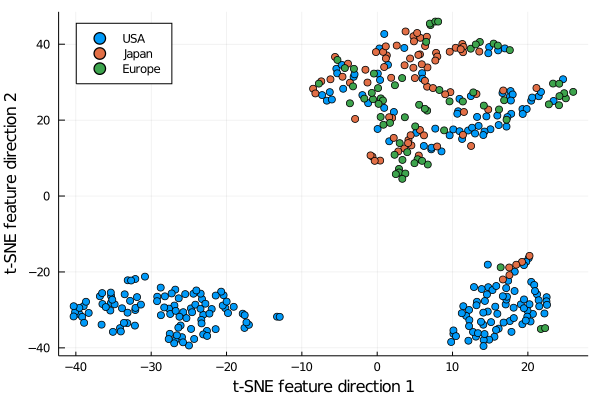

In [46]:
plot(legend=:topleft)
for (col_idx, origin_name) in enumerate(["USA", "Japan", "Europe"])
    scatter!(data_tsne[car_origins.==origin_name, 1], 
             data_tsne[car_origins.==origin_name, 2],
             color=col_idx,
             label=origin_name)
end
xlabel!("t-SNE feature direction 1")
ylabel!("t-SNE feature direction 2")

Although t-SNE separates the clusters more distinctly, the pattern which we saw in PCA still holds.

## UMAP

Finally we will look at a geometric (Riemannian) clustering technique: [Uniform Manifold Approximation and Projection](https://arxiv.org/pdf/1802.03426.pdf?kl=viewed)

> Being a Riemannian geometry method, UMAP operates on a distance function and not the data itself.

In [47]:
# use correlation as the distance metric
d_metric = cor(data, data, dims=2)
embedding = umap(d_metric, 2)

2×392 Array{Float64,2}:
 11.0777   11.6754   11.1044   11.2765  11.075    11.7074   11.5722   11.6231   11.6926   11.3      …  11.1098   -3.47263  -3.34569  -4.45063  -6.46993   -5.98929  -3.14974  -4.95147  -5.32046
  2.36529   2.43514   2.94851   2.3357   2.88631   3.27835   3.40541   3.31729   3.40166   3.21212      3.06852   2.64417   2.82685  -4.56844  -0.221832  -4.04183   2.67155  -4.5115   -4.50493

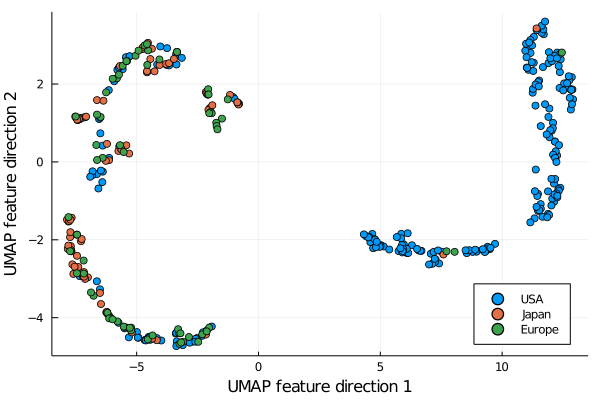

In [48]:
plot(legend=:bottomright)
for (col_idx, origin_name) in enumerate(["USA", "Japan", "Europe"])
    scatter!(embedding[1, car_origins.==origin_name], 
             embedding[2, car_origins.==origin_name],
             color=col_idx,
             label=origin_name)
end
xlabel!("UMAP feature direction 1")
ylabel!("UMAP feature direction 2")

We can try out using regular Euclidean distances which we will pass from the `Distances.jl` package:

In [50]:
d_euclid = pairwise(Euclidean(), data, data, dims=1)
embedding_euclid = umap(-d_euclid, 2)

2×392 Array{Float64,2}:
 -7.06839  -8.66243  -7.60979  -7.53037  -7.49272  -10.0315     -10.2983    -10.2831   -10.314     …  5.92829  -1.92482  6.91252  7.4261  4.18214  5.19636  4.10429  7.53196  4.27871  4.25804
 -5.51927  -2.67113  -5.1004   -5.15045  -5.23247   -0.0326089    0.435201    0.43504    0.426861     1.91457  -8.78156  3.49552  5.5211  2.87554  2.60054  7.91688  5.3108   4.16991  4.35457

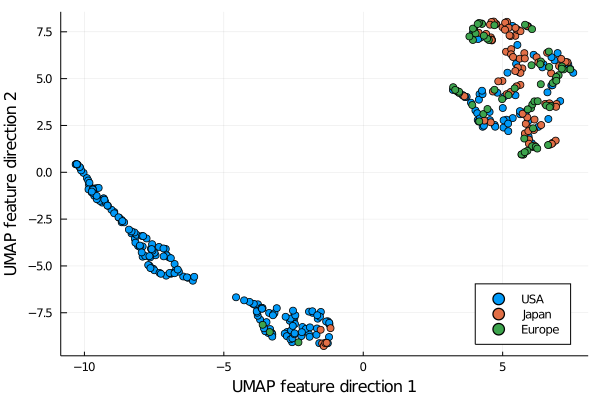

In [51]:
plot(legend=:bottomright)
for (col_idx, origin_name) in enumerate(["USA", "Japan", "Europe"])
    scatter!(embedding_euclid[1, car_origins.==origin_name], 
             embedding_euclid[2, car_origins.==origin_name],
             color=col_idx,
             label=origin_name)
end
xlabel!("UMAP feature direction 1")
ylabel!("UMAP feature direction 2")

We see that even with UMAP, the same pattern holds with US cars dominating two of the clusters and Japanese and European cars covering the rest.